# Урок 5. Случайный лес

**1. Сформировать с помощью sklearn.make_classification датасет из 1000 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50, 100, 200 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote). Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.**

**2 (опция). Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.**

In [4]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [5]:
# сгенерируем данные, представляющие собой 500 объектов с 5-ю признаками
classification_data, classification_labels = datasets.make_classification(n_samples=1000,
                                                      n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=23)

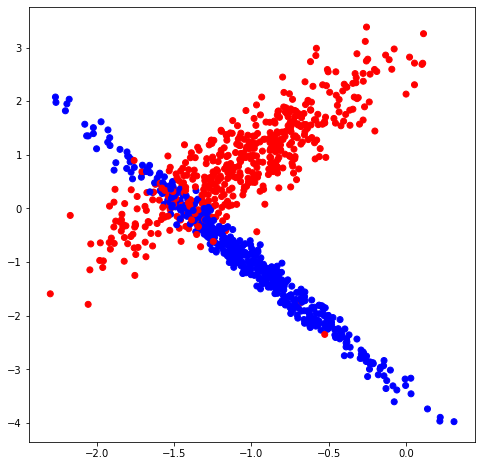

In [6]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [7]:
random.seed(42)
 
def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]            
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [8]:
def get_subsample(len_sample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    len_subsample = int(np.sqrt(len_sample))
    subsample = []
    
    random.shuffle(sample_indexes)
    for _ in range(len_subsample):
        subsample.append(sample_indexes.pop())
        
    return subsample

In [9]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [10]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
            
        # найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction        

In [11]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [12]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [13]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [14]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf_samples = 5

    root_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    feature_subsample_indices = get_subsample(n_features) # выбираем случайные признаки
    
    for index in feature_subsample_indices:
        # будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique(data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf_samples or len(false_data) < min_leaf_samples:
                continue
            
            current_quality = quality(true_labels, false_labels, root_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [15]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [16]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
        
    return forest

In [17]:
# Функция классификации отдельного объекта

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [18]:
# функция формирования предсказания по выборке на одном дереве

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [19]:
# предсказание голосованием деревьев

def tree_vote(forest, data):

    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree))
    
    # сформируем список с предсказаниями для каждого объекта
    predictions_per_object = list(zip(*predictions))
    
    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count))
        
    return voted_predictions

In [20]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [21]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.25,
                                                                                     random_state = 3)

In [22]:
numbers_trees = np.array([1, 3, 10, 50, 100, 200])

Количество деревьев: 1 train: 92.40000
Количество деревьев: 1 test: 88.40000
-------------------------------------------------


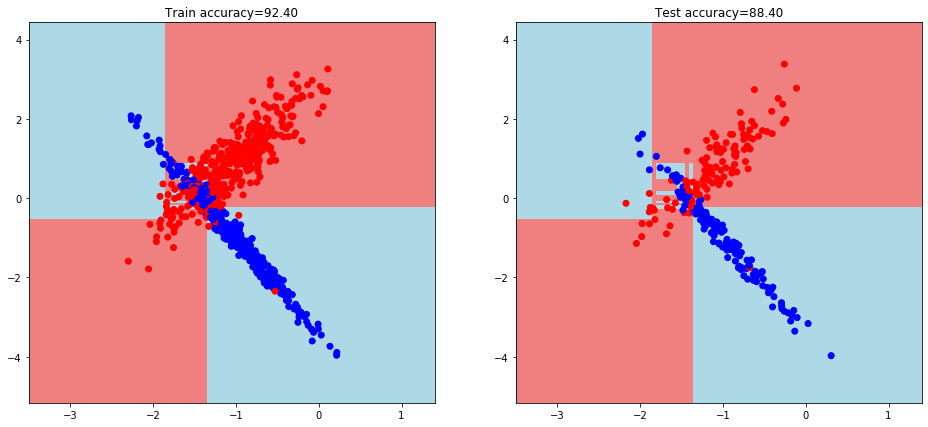

Количество деревьев: 3 train: 94.00000
Количество деревьев: 3 test: 88.40000
-------------------------------------------------


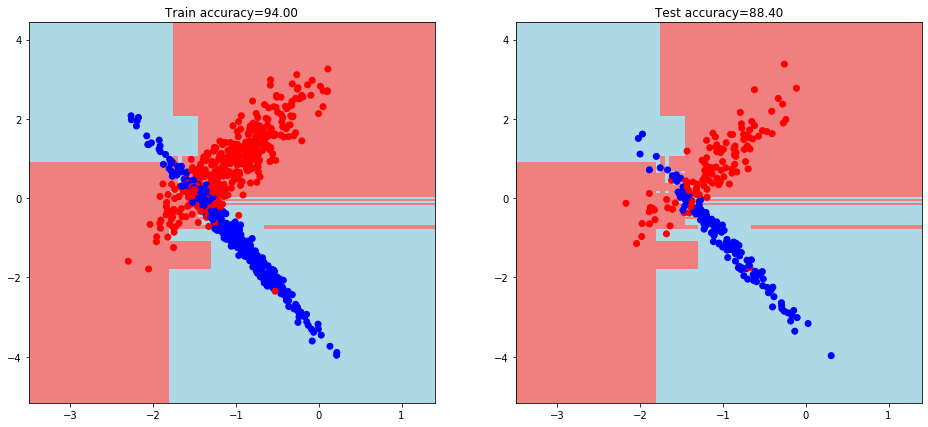

Количество деревьев: 10 train: 96.00000
Количество деревьев: 10 test: 93.20000
-------------------------------------------------


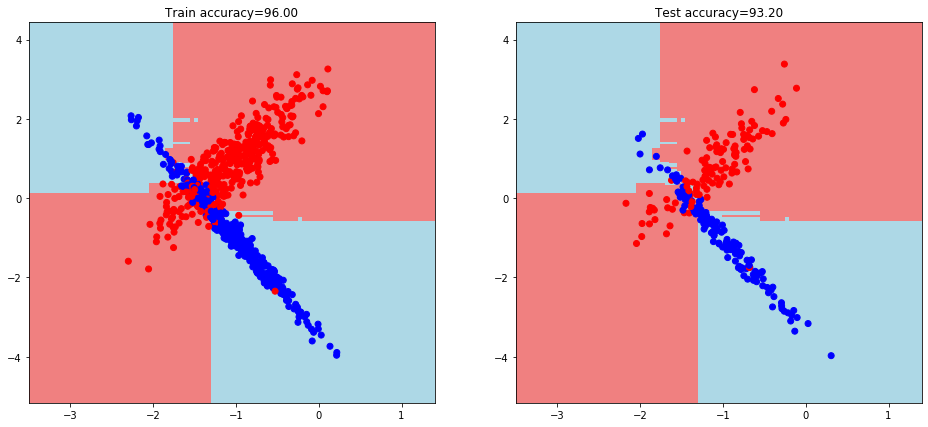

Количество деревьев: 50 train: 96.53333
Количество деревьев: 50 test: 90.40000
-------------------------------------------------


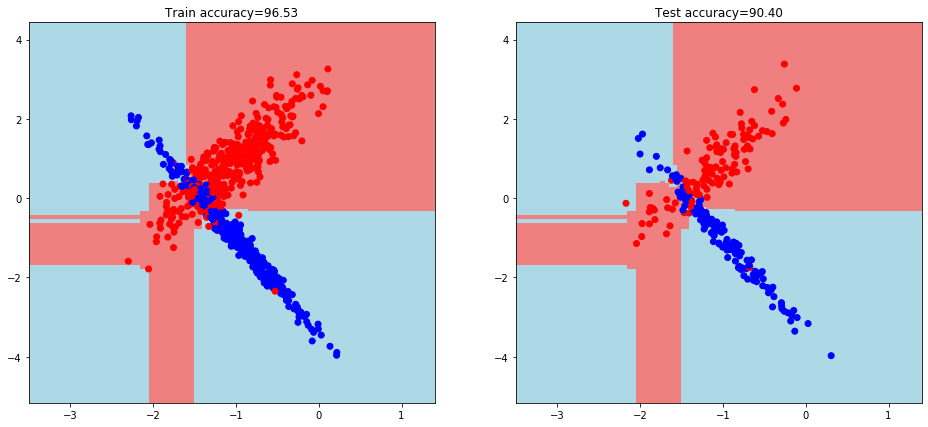

Количество деревьев: 100 train: 96.53333
Количество деревьев: 100 test: 92.80000
-------------------------------------------------


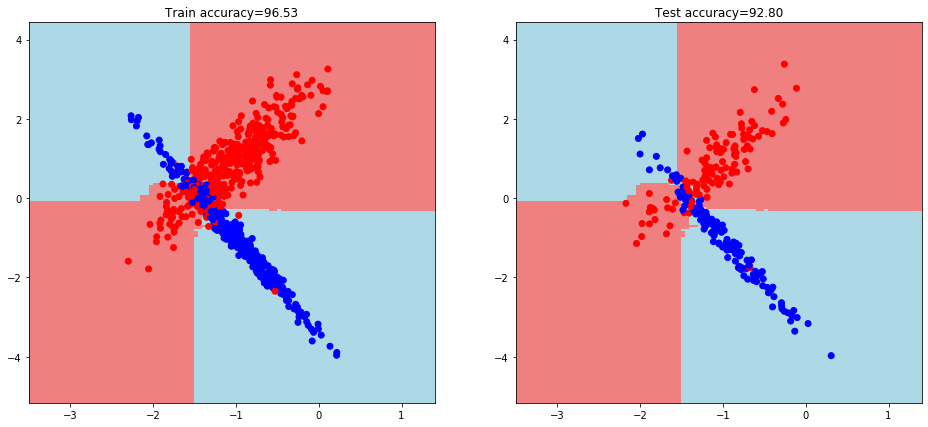

Количество деревьев: 200 train: 96.40000
Количество деревьев: 200 test: 92.00000
-------------------------------------------------


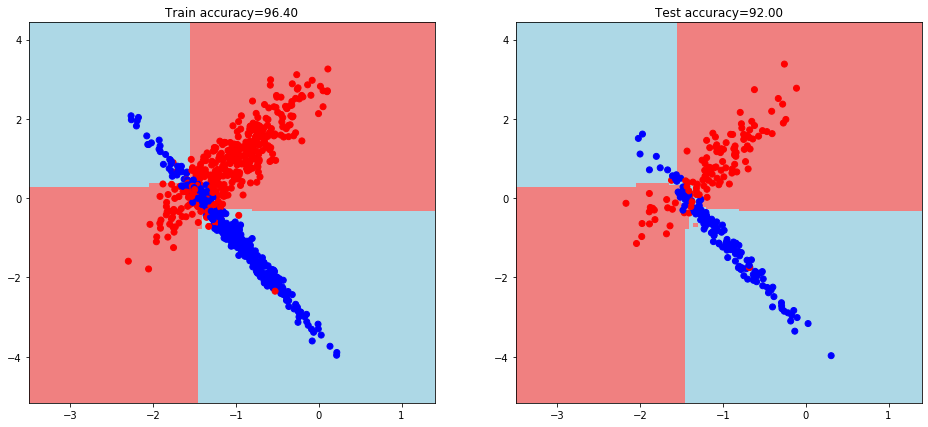

In [24]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
        x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
        y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
        return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))



for n in numbers_trees:
    my_forest = random_forest(train_data, train_labels, n)
    
    
    train_answers = tree_vote(my_forest, train_data)
    test_answers = tree_vote(my_forest, test_data)
    train_accuracy = accuracy_metric(train_labels, train_answers)
    print(f'Количество деревьев: {n} train: {train_accuracy:.5f}')
    test_accuracy = accuracy_metric(test_labels, test_answers)
    print(f'Количество деревьев: {n} test: {test_accuracy:.5f}')
    print('-------------------------------------------------')
    
    plt.figure(figsize = (16, 7))
    
    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(my_forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')
    
    plt.show()

## Выводы: при увеличении количества деревьев точность на трейне увеличивается, на тесте метрика точности глобально увеличивается тоже, хотя на некоторых выборках бывает, что меньшее количество дает лучшую метрику точности. 

**2 (опция). Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.**

При использовании Out-of-Bag нет необходимости делить на трейн и тест, нужно создать множество объектов, не вошедших в бутстрап.

In [60]:
random.seed(42)
 
def get_bootstrap_new(data, labels, N):
    n_samples = data.shape[0]
    bootstrap_new = []
    bootstrap_taken_ind = []
    
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]
            bootstrap_taken_ind.append(sample_index)
        bootstrap_new.append((b_data, b_labels))
    

    ind = np.arange(data.shape[0]-1)
    out_of_bag_ind = ind[~np.isin(ind, bootstrap_taken_ind)] 
        
    return bootstrap_new, out_of_bag_ind, bootstrap_taken_ind

In [61]:
a,b,c = get_bootstrap_new(train_data, train_labels, 1)

In [62]:
b

array([  4,  10,  12,  13,  14,  16,  17,  18,  22,  23,  26,  31,  33,
        34,  35,  37,  38,  41,  43,  49,  50,  53,  54,  56,  61,  64,
        66,  68,  76,  78,  84,  88,  90,  91,  92,  97,  98, 101, 107,
       113, 115, 116, 119, 120, 121, 125, 126, 129, 132, 139, 140, 144,
       145, 147, 148, 149, 153, 155, 157, 160, 164, 171, 172, 174, 176,
       177, 179, 184, 185, 188, 189, 191, 192, 193, 195, 198, 200, 202,
       206, 207, 210, 212, 213, 221, 226, 229, 231, 232, 237, 239, 241,
       247, 251, 256, 258, 259, 261, 262, 263, 264, 272, 275, 277, 280,
       282, 286, 287, 289, 294, 295, 297, 298, 299, 301, 304, 310, 313,
       318, 320, 325, 326, 328, 330, 333, 337, 342, 349, 350, 354, 355,
       356, 361, 364, 365, 368, 369, 374, 375, 376, 377, 380, 381, 383,
       384, 385, 386, 395, 396, 397, 400, 401, 402, 404, 406, 407, 411,
       419, 423, 426, 427, 428, 431, 434, 439, 442, 443, 447, 449, 451,
       454, 455, 457, 458, 461, 463, 474, 480, 482, 483, 485, 48

In [46]:
c = np.array(c)
c

array([736, 106, 398, 161,  69,  52, 538, 588, 168, 244, 283, 593, 529,
       177, 580, 662, 192, 327, 174, 518,  54, 670,  63, 430, 113, 178,
       384, 563, 596, 671, 610, 509,  75, 732, 594, 471, 242, 727, 487,
       326, 235, 234, 387, 143, 308, 260, 580, 127, 304, 286, 635, 549,
       717, 242, 502, 370, 505, 359, 437, 558, 488, 613, 468, 504, 678,
       459, 202, 217, 513, 343, 633, 449, 362, 259, 296, 581, 338,  75,
       380, 433, 416, 469, 267, 618, 146, 738, 671, 620, 473, 530,  79,
       141,  31, 410, 382, 737,  40, 448, 231, 696, 264, 574, 650, 494,
       678, 434, 195, 470, 333, 224, 245,  82, 145, 687, 216, 635, 321,
       636, 345, 400,  43, 178, 523, 494, 109, 485, 591, 325, 664, 727,
       180, 464,  24, 658,  13, 236, 131, 272, 423, 246, 610, 163, 672,
       571, 265, 641, 709, 545,  72, 188, 130, 425, 146, 106, 574,  31,
       384, 324, 619, 244,  21,  13, 470, 527,  54,  41, 442, 519, 470,
       128, 501, 360, 695, 580, 284, 305, 525, 272,  79,  77,  3

In [63]:
train_data.shape

(750, 2)

In [64]:
b.shape

(275,)

In [65]:
test_data_new = classification_data[b]

In [67]:
test_labels_new = classification_labels[b]

In [68]:
numbers_trees1 = np.array([1, 3, 10, 50])

Количество деревьев: 1 train: 92.26667
Количество деревьев: 1 test: 91.63636
-------------------------------------------------


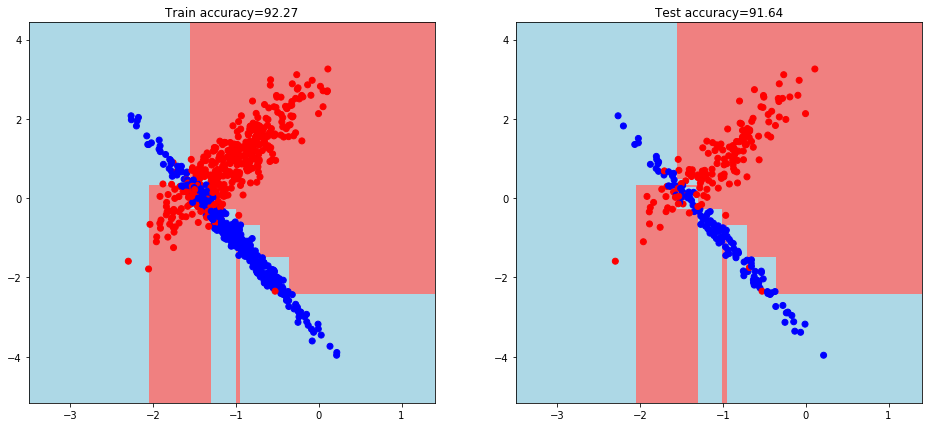

Количество деревьев: 3 train: 94.93333
Количество деревьев: 3 test: 94.18182
-------------------------------------------------


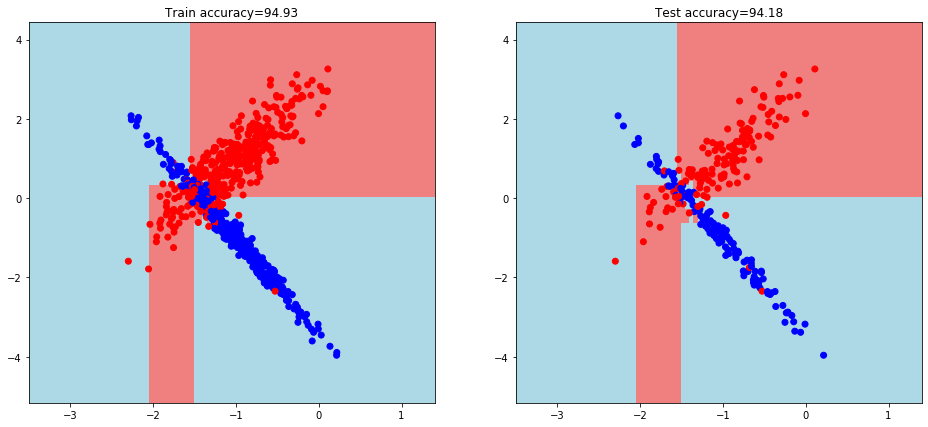

Количество деревьев: 10 train: 96.53333
Количество деревьев: 10 test: 94.90909
-------------------------------------------------


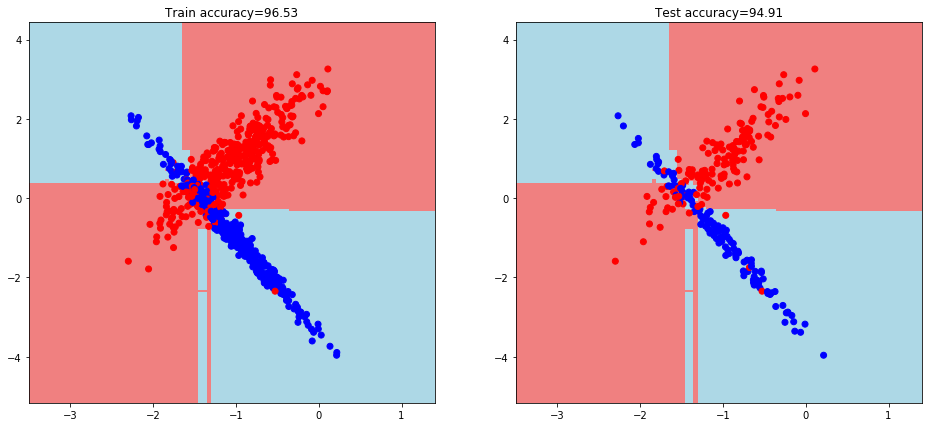

Количество деревьев: 50 train: 96.13333
Количество деревьев: 50 test: 96.72727
-------------------------------------------------


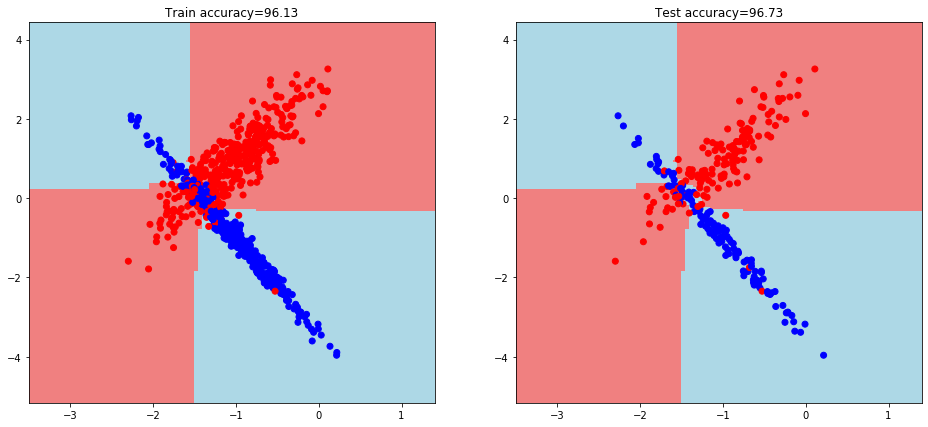

In [69]:
def get_meshgrid(data, step=.05, border=1.2):
        x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
        y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
        return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))



for n in numbers_trees1:
    my_forest = random_forest(train_data, train_labels, n)
    
    
    train_answers = tree_vote(my_forest, train_data)
    test_answers = tree_vote(my_forest, test_data_new)
    train_accuracy = accuracy_metric(train_labels, train_answers)
    print(f'Количество деревьев: {n} train: {train_accuracy:.5f}')
    test_accuracy = accuracy_metric(test_labels_new, test_answers)
    print(f'Количество деревьев: {n} test: {test_accuracy:.5f}')
    print('-------------------------------------------------')
    
    plt.figure(figsize = (16, 7))
    
    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(tree_vote(my_forest, np.c_[xx.ravel(), yy.ravel()])).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data_new[:, 0], test_data_new[:, 1], c = test_labels_new, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')
    
    plt.show()


**С использованием Out-of-Bag увеличилась точность на тесте, возможно, что предпочтительнее использовать валидацию на Out-of-Bag**